In [1]:
# pip install pandas numpy scikit-learn matplotlib yfinance tensorflow scikeras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor

from graphing import graph_normal, show_results
from get_data import get_apple_stock_split

2024-12-29 22:20:57.709038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train, X_test, Y_train, Y_test = get_apple_stock_split(scaler_X, scaler_Y)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

[*********************100%***********************]  1 of 1 completed

Training samples: 1571, Testing samples: 393


In [4]:
#repeatable way to create the model 
def create_ann(neurons=32, activation='relu', optimizer='admin'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  #input structure
    model.add(Dense(neurons, activation=activation)) # hidden layer
    model.add(Dense(neurons, activation=activation)) # hidden layer
    model.add(Dense(1)) #output
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

<h1> GridSearch setup </h1>

In [6]:
# defone model parameters and create model
# param_grid = {
#     'model__neurons': [16, 32, 64, 128],
#     'model__activation': ['relu', 'tanh', 'sigmoid'],
#     'model__optimizer': ['adam', 'sgd'],
#     'batch_size': [16, 32],
#     'epochs': [50, 100, 200]
# }
param_grid = {
    'model__neurons': [16],
    'model__activation': ['relu'],
    'model__optimizer': ['adam'],
    'batch_size': [32],
    'epochs': [50]
}

In [7]:
#training
model = KerasRegressor(model=create_ann, verbose=0) #keras regressor is a wrapper to us scikit learn gid search


# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,                       # cross-validation
    scoring='neg_mean_absolute_error',         # Use mse as scoring
    verbose=1,
    n_jobs=-1                   # Use all available cores
)

# Perform grid search on training data
grid_search.fit(X_train, Y_train)

results_df = pd.DataFrame(grid_search.cv_results_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


2024-12-29 22:21:08.007488: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-29 22:21:08.130436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-29 22:21:08.147485: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
# for i, row in results_df.iterrows():
#     print(f"Rank {row['rank_test_score']}:")
#     print(f"Parameters: {row['params']}")
#     print(f"Mean Test Score: {row['mean_test_score']:.4f}")
#     print(f"Std Dev of Test Score: {row['std_test_score']:.4f}")
#     print("-" * 30)

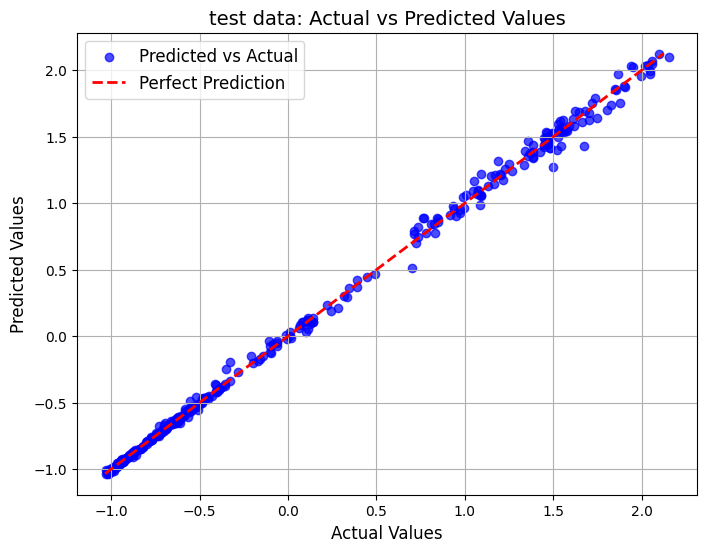

test data  MAE: 0.02372763396253044
test data  RMSE: 0.039608439030195106


In [9]:
# use best model to predict
final_model = grid_search.best_estimator_

# Predict on test data
final_predictions = final_model.predict(X_test)

# Evaluate the final model
mae = mean_absolute_error(Y_test, final_predictions)
mse = mean_squared_error(Y_test, final_predictions)
rmse = np.sqrt(mse)

graph_normal(final_predictions, Y_test, "test data")

[*********************100%***********************]  1 of 1 completed


Final Model MAE: 0.2878691494396227
Final Model RMSE: 0.3696623020368138


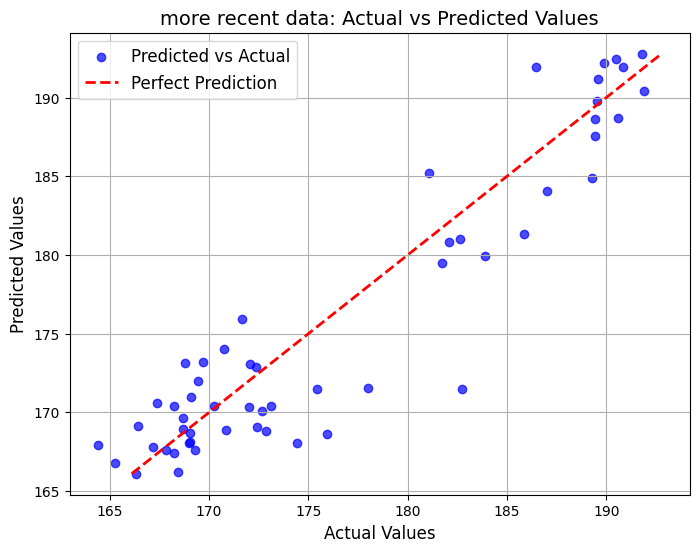

more recent data  MAE: 2.5524860728870737
more recent data  RMSE: 3.277732195498783


In [10]:
# trying to predict more recent ones
stock = yf.Ticker('AAPL')
data_to_predict = yf.download("AAPL", start="2024-01-01", end="2024-06-01")
data_to_predict['SMA_10'] = data_to_predict['Close'].rolling(window=10).mean()
data_to_predict['SMA_50'] = data_to_predict['Close'].rolling(window=50).mean()
data_to_predict['Price_Change'] = data_to_predict['Close'].pct_change()
data_to_predict['Target'] = data_to_predict['Close'].shift(-1)
data_to_predict.dropna(inplace=True)

X = data_to_predict[['SMA_10', 'SMA_50','Price_Change', 'High', 'Close', 'Open', 'Low']]
Y = data_to_predict['Target']

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.to_frame())

final_predictions = final_model.predict(X_scaled)
inverse_scaled_prediction = scaler_Y.inverse_transform(final_predictions.reshape(-1, 1))

mae = mean_absolute_error(Y_scaled, final_predictions)
mse = mean_squared_error(Y_scaled, final_predictions)
rmse = np.sqrt(mse)

print(f"Final Model MAE: {mae}")
print(f"Final Model RMSE: {rmse}")

graph_normal(inverse_scaled_prediction, Y, "more recent data")